In [63]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import gensim
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from pandas import read_excel
import nltk
import spacy

import numpy as np

import tensorflow as tf

# !pip install tensorflow-hub
# !pip install tensorflow-datasets
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report
import csv

import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
# print("Version: ", tf.__version__)
# print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
# print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Load training and testing data

Please upload the P1_training.xslx and P1_testing.xslx files to the left hand folder section here.

In [172]:
# find your sheet name at the bottom left of your excel file and assign 
# it to my_sheet 
my_sheet = 'Sheet1' # change it to your sheet name
file_name = 'P1_training.xlsx' # change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)
# print(df.head()) # shows headers with top 5 rows

sentences = df['sentence'].to_list()
labels = df['label'].to_list()

In [173]:
# find your sheet name at the bottom left of your excel file and assign 
# it to my_sheet 
my_sheet = 'P1_testing' # change it to your sheet name
file_name = 'P1_testing.xlsx' # change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)
# print(df.head()) # shows headers with top 5 rows

test_sentences = df['sentence'].to_list()
test_labels = df['label'].to_list()

## Preprocessing Data (Basic)

1. Stemming
2. Lemmatization
3. Tokenization

In [141]:
def lemmatizeSentences(sentences):
    lemmatizedSentences = []
    for sentence in sentences:
        wordnet_lemmatizer = WordNetLemmatizer()

        punctuations="?:!.,;"
        sentence_words = nltk.word_tokenize(sentence)
        for word in sentence_words:
            if word in punctuations:
                sentence_words.remove(word)

        lemmatizedSentences.append("".join([wordnet_lemmatizer.lemmatize(word) + " " for word in sentence_words]))
    return lemmatizedSentences

sentences = lemmatizeSentences(sentences)
test_sentences = lemmatizeSentences(test_sentences)

In [27]:
# Use porter stemmer to stem sentences
def stemSentences(sentences, stemmer):
    stemmed_sentences = []
    for sentence in sentences:
        token_words=word_tokenize(sentence)
        token_words
        stem_sentence=[]
        for word in token_words:
            stem_sentence.append(stemmer.stem(word))
            stem_sentence.append(" ")
        stemmed_sentences.append("".join(stem_sentence))
    return stemmed_sentences

sentences = stemSentences(sentences, PorterStemmer())
test_sentences = stemSentences(test_sentences, PorterStemmer())

In [174]:
tokenized_sentences = [word_tokenize(s) for s in sentences]
test_tokenized_sentences = [word_tokenize(s) for s in test_sentences]
# tokenized_sentences
np.max([len(s) for s in tokenized_sentences]), np.max([len(s) for s in test_tokenized_sentences])
# tokenized_sentences[0]

(142, 151)

## Baseline models

Let's consider two baseline models:
1. word2Vec
2. spacy
3. GloVe

#### Utility functions

In [67]:
def getSentenceVectors(tokenized_sentences, model, vec_size):
    vectors = []

    for i, s in enumerate(tokenized_sentences):
        vector = np.zeros(vec_size,)
        for j, token in enumerate(s):
            if model.__contains__(token):
                vector += model[token]
        vectors.append(vector)
        
    return vectors

### [Baseline model 1] Using Spacy for Word Embeddings 

Using spacy, we can get word embeddings for the individual words in a sentence. Also, the same object can be used to get the overall average word embedding for all the tokens in a sentence.

In [163]:
# Uncomment the following line to download the package needed for spacy word embeddings
!python3 -m spacy download en_core_web_md

# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')

# process a sentence using the model
doc = nlp("This is fs. ,some:d text that:d I am processing with Spacy")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [164]:
sentence_vectors = []
test_sentence_vectors = []

for s in test_sentences:
  test_sentence_vectors.append(nlp(s).vector)

for s in sentences:
  sentence_vectors.append(nlp(s).vector)

len(sentence_vectors), len(test_sentence_vectors)

(1660, 683)

#### Create training and test data

In [165]:
X_train = sentence_vectors
y_train = labels
X_test = test_sentence_vectors
y_test = test_labels

In [166]:
X_train, X_val, y_train, y_val = train_test_split(sentence_vectors, labels)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Train a classifier

In [167]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Accuracy scores and metrics

In [168]:
print('Accuracy of classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on validation set: {:.2f}'
     .format(clf.score(X_val, y_val)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of classifier on training set: 0.70
Accuracy of classifier on validation set: 0.61
Accuracy of classifier on test set: 0.63


In [169]:
target_names = ['class 0', 'class 1', 'class 2']
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.50      0.01      0.02        82
     class 1       0.60      0.81      0.69       303
     class 2       0.69      0.62      0.65       298

    accuracy                           0.63       683
   macro avg       0.59      0.48      0.45       683
weighted avg       0.62      0.63      0.59       683



### [Baseline model 2] Using Word2Vec model for word embeddings

In [29]:
!wget -P model -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-09-06 08:24:54--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘model/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.2MB/s    in 96s     

2020-09-06 08:26:30 (16.4 MB/s) - ‘model/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [25]:
# Load Google's pre-trained Word2Vec model.
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin.gz', binary=True)  

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The following function creates the vectors for the sentences after tokenizing a sentence and then iterating over the words/tokens and averaging their individual vectors.

In [143]:
def getSentenceVectors(tokenized_sentences, model, vec_size):
    vectors = []

    for i, s in enumerate(tokenized_sentences):
        vector = np.zeros(vec_size,)
        for j, token in enumerate(s):
            if model.__contains__(token):
                vector += model[token]
        vectors.append(vector)
        
    return vectors

In [144]:
sentence_vectors = getSentenceVectors(tokenized_sentences, model_w2v, model_w2v.vector_size)
test_sentence_vectors = getSentenceVectors(test_tokenized_sentences, model_w2v, model_w2v.vector_size)

In [145]:
X_train = sentence_vectors
y_train = labels
X_test = test_sentence_vectors
y_test = test_labels

In [146]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Training a classifier

In [147]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Accuracy scores and metrics

In [148]:
print('Accuracy of classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on validation set: {:.2f}'
     .format(clf.score(X_val, y_val)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of classifier on training set: 0.73
Accuracy of classifier on validation set: 0.63
Accuracy of classifier on test set: 0.62


In [149]:
target_names = ['class 0', 'class 1', 'class 2']
y_pred = clf.predict(X_test)
with open('testing_output_word2vec.csv', 'w', newline='') as csvfile:
    fieldnames = ['sentence', 'gold_label', 'predicted_label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(test_sentences)):
        writer.writerow({'sentence': test_sentences[i], 'gold_label': y_pred[i], 'predicted_label': y_test[i]})
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.11      0.01      0.02        82
     class 1       0.60      0.79      0.68       303
     class 2       0.68      0.62      0.65       298

    accuracy                           0.62       683
   macro avg       0.46      0.48      0.45       683
weighted avg       0.57      0.62      0.59       683



### [Baseline model 3] Using GloVe for word embeddings

In [39]:
!wget -P model -c http://nlp.stanford.edu/data/glove.6B.zip

--2020-09-06 08:44:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-06 08:44:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-06 08:44:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘model/glove.6B.zip’

g

In [42]:
%cd model/
!unzip glove*.zip
%cd ../

/content/model
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
/content


In [84]:
embeddings_dict = {}
with open("model/glove.6B.50d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
model_glove = embeddings_dict

In [175]:
sentence_vectors = getSentenceVectors(tokenized_sentences, model_glove, 50)
test_sentence_vectors = getSentenceVectors(test_tokenized_sentences, model_glove, 50)

In [176]:
X_train = sentence_vectors
y_train = labels
X_test = test_sentence_vectors
y_test = test_labels

In [177]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# y_train[3], labels[3]

#### Train a classifier

In [178]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Accuracy scores and metrics

In [179]:
print('Accuracy of classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on validation set: {:.2f}'
     .format(clf.score(X_val, y_val)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of classifier on training set: 0.62
Accuracy of classifier on validation set: 0.56
Accuracy of classifier on test set: 0.62


In [180]:
target_names = ['class 0', 'class 1', 'class 2']
y_pred = clf.predict(X_test)
with open('testing_output_glove.csv', 'w', newline='') as csvfile:
    fieldnames = ['sentence', 'gold_label', 'predicted_label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(test_sentences)):
        writer.writerow({'sentence': test_sentences[i], 'gold_label': y_pred[i], 'predicted_label': y_test[i]})
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        82
     class 1       0.61      0.76      0.67       303
     class 2       0.63      0.65      0.64       298

    accuracy                           0.62       683
   macro avg       0.41      0.47      0.44       683
weighted avg       0.55      0.62      0.58       683



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparison of Baseline Models

1. Spacy F1 = 0.58, Acc = 0.62, ValAcc = 0.61, TrainAcc = 0.71
2. Word2Vec F1 = 0.59, Acc = 0.63, ValAcc = 0.42, TrainAcc = 0.67
3. GloVe F1 = 0.57, Acc = 0.61, ValAcc = 0.55, TrainAcc = 0.63

## Proposed Solution

1. Universal Sentence Encoder with Simple Classifier
2. Universal Sentence Encoder with Artificial Neural Network and training

### [Improvement 1] Using Universal Sentence Encoder for sentence embeddings with a simple classifier

In [91]:
# module_use_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
module_use_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"

model_use = hub.load(module_use_url)
print ("module %s loaded" % module_use_url)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [119]:
def embed_use(input):
    vectors = []
    output = model_use(input)
    for i in range(output.shape[0]):
        vectors.append(output[i])
    return vectors

In [157]:
sentence_vectors = embed_use(sentences)
test_sentence_vectors = embed_use(test_sentences)

In [158]:
X_train = sentence_vectors
y_train = labels
X_test = test_sentence_vectors
y_test = test_labels

In [159]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#### Train a classifier

In [160]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Accuracy scores and metrics

In [161]:
print('Accuracy of classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of classifier on validation set: {:.2f}'
     .format(clf.score(X_val, y_val)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of classifier on training set: 0.89
Accuracy of classifier on validation set: 0.66
Accuracy of classifier on test set: 0.63


In [162]:
target_names = ['class 0', 'class 1', 'class 2']
y_pred = clf.predict(X_test)
with open('testing_output_proposed.csv', 'w', newline='') as csvfile:
    fieldnames = ['sentence', 'gold_label', 'predicted_label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(test_sentences)):
        writer.writerow({'sentence': test_sentences[i], 'gold_label': y_pred[i], 'predicted_label': y_test[i]})
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.22      0.06      0.10        82
     class 1       0.60      0.80      0.68       303
     class 2       0.72      0.62      0.67       298

    accuracy                           0.63       683
   macro avg       0.51      0.49      0.48       683
weighted avg       0.61      0.63      0.61       683



## Comparison of Performance

Comparison with baseline (without lemmatization/stemming)

1. Spacy F1 = 0.58, Acc = 0.62, ValAcc = 0.61, TrainAcc = 0.71
2. Word2Vec F1 = 0.59, Acc = 0.63, ValAcc = 0.42, TrainAcc = 0.67
3. GloVe F1 = 0.57, Acc = 0.61, ValAcc = 0.55, TrainAcc = 0.63
4. USE F1 = 0.64, Acc = 0.66, ValAcc = 0.67, TrainAcc = 0.90

Comparison with baseline (with lemmatization/stemming)

1. Spacy F1 = 0.59, Acc = 0.63, ValAcc = 0.61, TrainAcc = 0.70
2. Word2Vec F1 = 0.59, Acc = 0.62, ValAcc = 0.63, TrainAcc = 0.73
3. GloVe F1 = 0.58, Acc = 0.62, ValAcc = 0.59, TrainAcc = 0.64
4. USE F1 = 0.61, Acc = 0.63, ValAcc = 0.66, TrainAcc = 0.89

#### Plot of classification performance without lemmatization/stemming

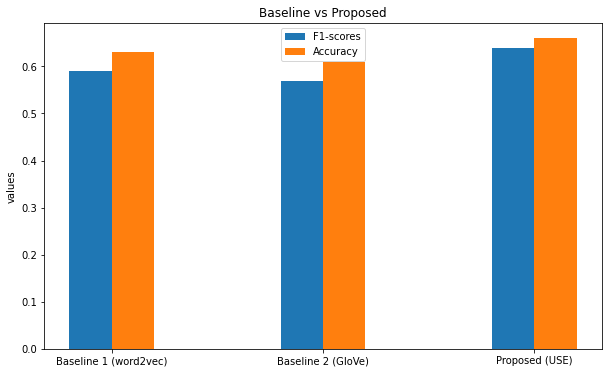

In [105]:
f1_vals = [0.59, 0.57, 0.64]
acc_vals = [0.63, 0.61, 0.66]
val_acc_vals = [0.42, 0.55, 0.67]
train_acc_vals = [0.67, 0.63, 0.90]

labels = ['Baseline 1 (word2vec)', 'Baseline 2 (GloVe)', 'Proposed (USE)']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, f1_vals, width, label='F1-scores')
rects2 = ax.bar(x + width/2, acc_vals, width, label='Accuracy')
# rects3 = ax.bar(x + width/4, val_acc_vals, width, label='Validation Accuracy')
# rects4 = ax.bar(x + 3*width/4, train_acc_vals, width, label='Training Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('values')
ax.set_title('Baseline vs Proposed')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Plot of classification performance With lemmatization/stemming

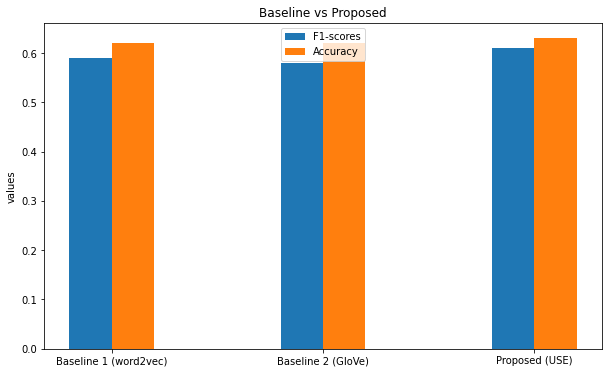

In [171]:
f1_vals = [0.59, 0.58, 0.61]
acc_vals = [0.62, 0.62, 0.63]
val_acc_vals = [0.63, 0.59, 0.66]
train_acc_vals = [0.73, 0.64, 0.89]

labels = ['Baseline 1 (word2vec)', 'Baseline 2 (GloVe)', 'Proposed (USE)']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, f1_vals, width, label='F1-scores')
rects2 = ax.bar(x + width/2, acc_vals, width, label='Accuracy')
# rects3 = ax.bar(x + width/4, val_acc_vals, width, label='Validation Accuracy')
# rects4 = ax.bar(x + 3*width/4, train_acc_vals, width, label='Training Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('values')
ax.set_title('Baseline vs Proposed')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


### [Improvement 2] Experimenting with Artificial Neural Network

In [6]:
import os
paths = ["P1", "P1/test", "P1/train", "P1/train/class_0", "P1/train/class_1", "P1/train/class_2", "P1/test/class_0", "P1/test/class_1", "P1/test/class_2"]

for path in paths:
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)
    
label_counter = {0:1, 1:1, 2:1}
for i, s in enumerate(sentences):
    filename = "P1/train/class_%d/%d_text_%d.txt"%(labels[i], labels[i], label_counter[labels[i]]) 
    label_counter[labels[i]] += 1
    with open(filename, "w") as fp:
        fp.write(s)
        
label_counter = {0:1, 1:1, 2:1}
for i, s in enumerate(test_sentences):
    filename = "P1/test/class_%d/%d_text_%d.txt"%(test_labels[i], test_labels[i], label_counter[test_labels[i]]) 
    label_counter[test_labels[i]] += 1
    with open(filename, "w") as fp:
        fp.write(s)

Creation of the directory P1 failed
Creation of the directory P1/test failed
Creation of the directory P1/train failed
Creation of the directory P1/train/class_0 failed
Creation of the directory P1/train/class_1 failed
Creation of the directory P1/train/class_2 failed
Creation of the directory P1/test/class_0 failed
Creation of the directory P1/test/class_1 failed
Creation of the directory P1/test/class_2 failed


#### Create the dataset from given training and test data

In [19]:
batch_size = 16
seed = 15

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'P1/train', 
    batch_size=batch_size, 
    validation_split=0.05, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'P1/train', 
    batch_size=batch_size, 
    validation_split=0.05, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'P1/test', 
    batch_size=batch_size)

Found 1660 files belonging to 3 classes.
Using 1577 files for training.
Found 1660 files belonging to 3 classes.
Using 83 files for validation.
Found 683 files belonging to 3 classes.


In [20]:
train_examples_batch, train_labels_batch = next(iter(raw_train_ds))
first_review, first_label = train_examples_batch[1], train_labels_batch[1]
first_review

<tf.Tensor: shape=(), dtype=string, numpy=b"kevin smith must be a very likable person because several good sports took a ton of kidding in this feature , most notably miramax , the studio whose subsidiary , dimension films , is jay and silent bob's distributor .">

In [48]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
# embedding = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
# hub_layer(train_examples_batch[:])

In [50]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(3))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 147,371,395
Trainable params: 147,371,395
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
history = model.fit(raw_train_ds,
                    epochs=1,
                    validation_data=raw_val_ds,
                    verbose=1)

99/99 [==============================] - 297s 3s/step - loss: 0.9692 - accuracy: 0.5491 - val_loss: 1.0393 - val_accuracy: 0.5181


In [13]:
loss, accuracy = model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

NameError: ignored